In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\Max\anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Max\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\Max\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
data = pd.read_csv('BF_df_CTU.csv')
data.head()

,EX1G,EX2G,A1G,A2G,C1G,C2G,ES1G,ES2G,O1G,O2G,CONDITION
0,4,4,4,4,4,5,4,4,4,4,H
1,4,2,2,4,4,5,3,4,4,4,H
2,4,2,2,4,4,4,3,4,4,4,H
3,4,2,2,4,2,4,5,5,4,2,H
4,3,2,3,4,5,5,4,4,5,5,H


In [3]:
n,p = data.shape
x_real = data.iloc[:n//2,:-1]
x_fake = data.iloc[n//2:,:-1]

In [56]:
np.random.seed(0)
index = np.random.choice([0,1,2], size=n//2, p=[0.8,0.1,0.1])

x_real_smalltrain = x_real[index==0]
x_real_val = x_real[index==1]
x_real_test = x_real[index==2]

x_fake_smalltrain = x_fake[index==0]
x_fake_val = x_fake[index==1]
x_fake_test = x_fake[index==2]

x_real_train = x_real[index!=2]
x_fake_train = x_fake[index!=2]

# Exploratory analysis
In which way people are faking?
Let's plot some example of the true vs the fake responses of the same subject

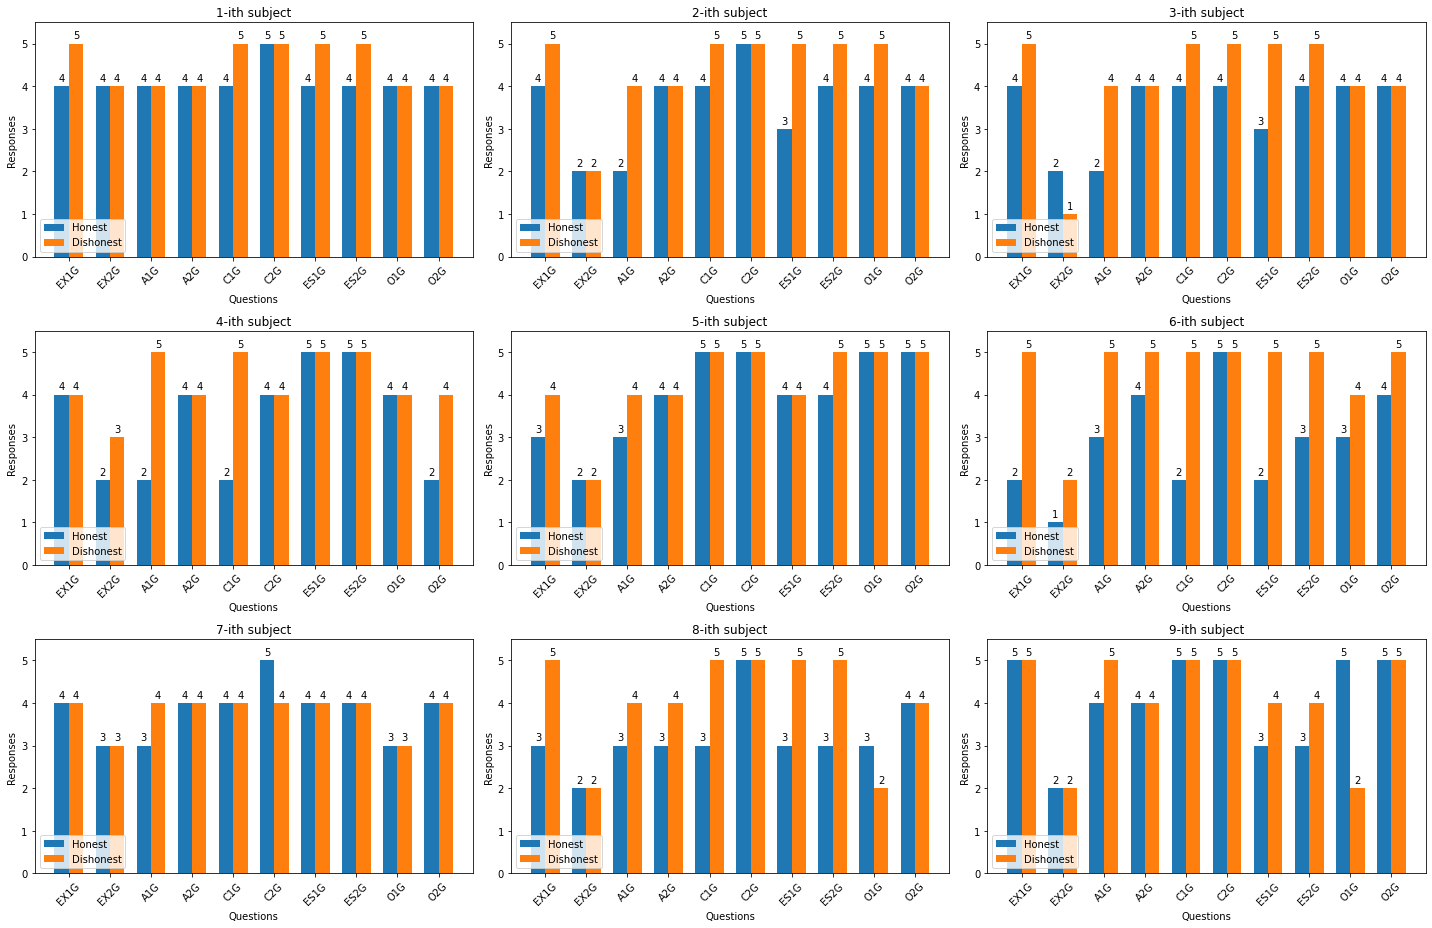

In [57]:
fig, ax = plt.subplots(3,3, figsize=(20, 13))

for i in range(9):

    row = int(i/3)
    col = i % 3

    labels = list(data.columns[:-1])

    honest = list(data.iloc[i,:-1])
    lier = list(data.iloc[n//2 + i,:-1])

    x = np.arange(len(labels))  
    width = 0.35  

    rects1 = ax[row, col].bar(x - width/2, honest, width, label='Honest')
    rects2 = ax[row, col].bar(x + width/2, lier, width, label='Dishonest')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax[row, col].set_title(str(i+1) + "-ith subject")
    ax[row, col].set_ylabel('Responses')
    ax[row, col].set_xlabel('Questions')
    ax[row, col].set_xticks(x)
    ax[row, col].set_xticklabels(labels, rotation=45)
    ax[row, col].legend(bbox_to_anchor=(0,0), loc="lower left")
    ax[row, col].set_ylim([0,5.5])

    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax[row, col].annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')


    autolabel(rects1)
    autolabel(rects2)

fig.tight_layout()

plt.show()

### Now let's see the mean of the differences

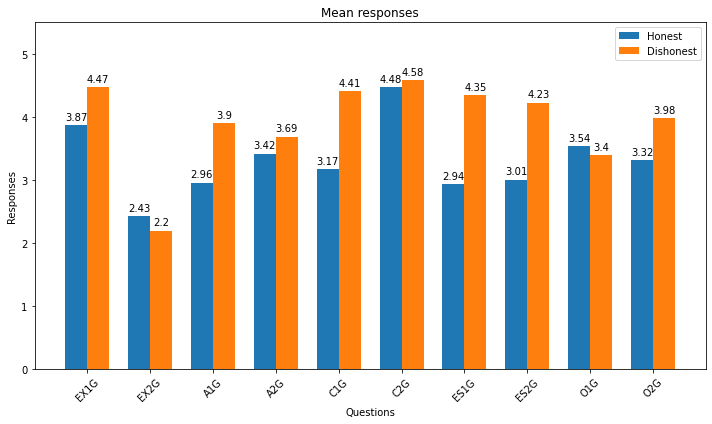

In [58]:
fig, ax = plt.subplots(1,1, figsize=(10, 6))

labels = list(data.columns[:-1])

honest = list(x_real.mean(0).round(2))
lier = list(x_fake.mean(0).round(2))

x = np.arange(len(labels))  
width = 0.35  

rects1 = ax.bar(x - width/2, honest, width, label='Honest')
rects2 = ax.bar(x + width/2, lier, width, label='Dishonest')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title("Mean responses")
ax.set_ylabel('Responses')
ax.set_xlabel('Questions')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.legend(bbox_to_anchor=(1,1), loc="upper right")
ax.set_ylim([0,5.5])

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

# Faking classification

In [49]:
y = np.array([1 if c == "D" else 0 for c in data["CONDITION"]])
X = data.iloc[:,:-1].copy()

In [51]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [118]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression(random_state=124, verbose=False, penalty="l1", solver="saga", max_iter=3000, C = 0.1)
_=LR.fit(X_train, y_train)

In [119]:
from sklearn.metrics import accuracy_score

y_hat = LR.predict(X_test)
print(f"Accuracy of regularized logistic regression: {accuracy_score(y_hat, y_test).round(2)}" ) 
print(f"There were {sum(y_hat != y_test)} errors on {len(y_test)} predictions")


Accuracy of regularized logistic regression: 0.91
There were 4 errors on 45 predictions


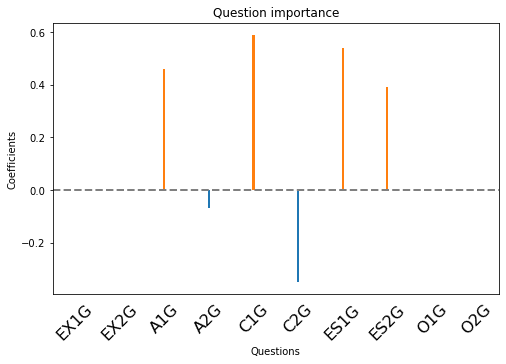

In [145]:
fig, ax = plt.subplots(figsize=(8, 5))

coef_df = pd.DataFrame({"varname" : list(data.columns)[:-1],
                        "coef" : LR.coef_.round(2)[0]})

coef_df.plot(x='varname', y='coef', kind='bar', 
             ax=ax, color='none', legend=False)
ax.set_xlabel('Questions')
ax.set_ylabel('Coefficients')
ax.set_title("Question importance")
ax.axhline(y=0, linestyle='--', color='gray', linewidth=2)

ax.bar(x=np.arange(coef_df.shape[0]), width=0.05,
           height=coef_df['coef'], color=["tab:blue" if c < 0 else "tab:green" if c == 0 else "tab:orange" for c in coef_df['coef']])

ax.xaxis.set_ticks_position('none')
_ = ax.set_xticklabels(list(data.columns)[:-1], 
                       rotation=45, fontsize=16)



As we can see the model does not watch EX and O questions for discriminating between honests and liers. C and ES seem to be the questions where the liers tend to fake more.

## Why are those predictions wrong? 

In [121]:
print("Misclassifications:")
errors = X_test.join(data["CONDITION"]).join(pd.Series(["D" if c == "H" else "H" for c in data["CONDITION"]], name="Prediction")).iloc[y_hat != y_test,:]
errors

Misclassifications:


,EX1G,EX2G,A1G,A2G,C1G,C2G,ES1G,ES2G,O1G,O2G,CONDITION,Prediction
116,5,2,2,4,5,5,5,4,3,2,H,D
79,5,2,4,3,5,4,3,3,2,3,H,D
75,4,1,5,3,2,5,5,4,5,3,H,D
199,5,1,4,5,5,5,5,5,5,5,H,D


### Comparison between misclassifications and typical behavior

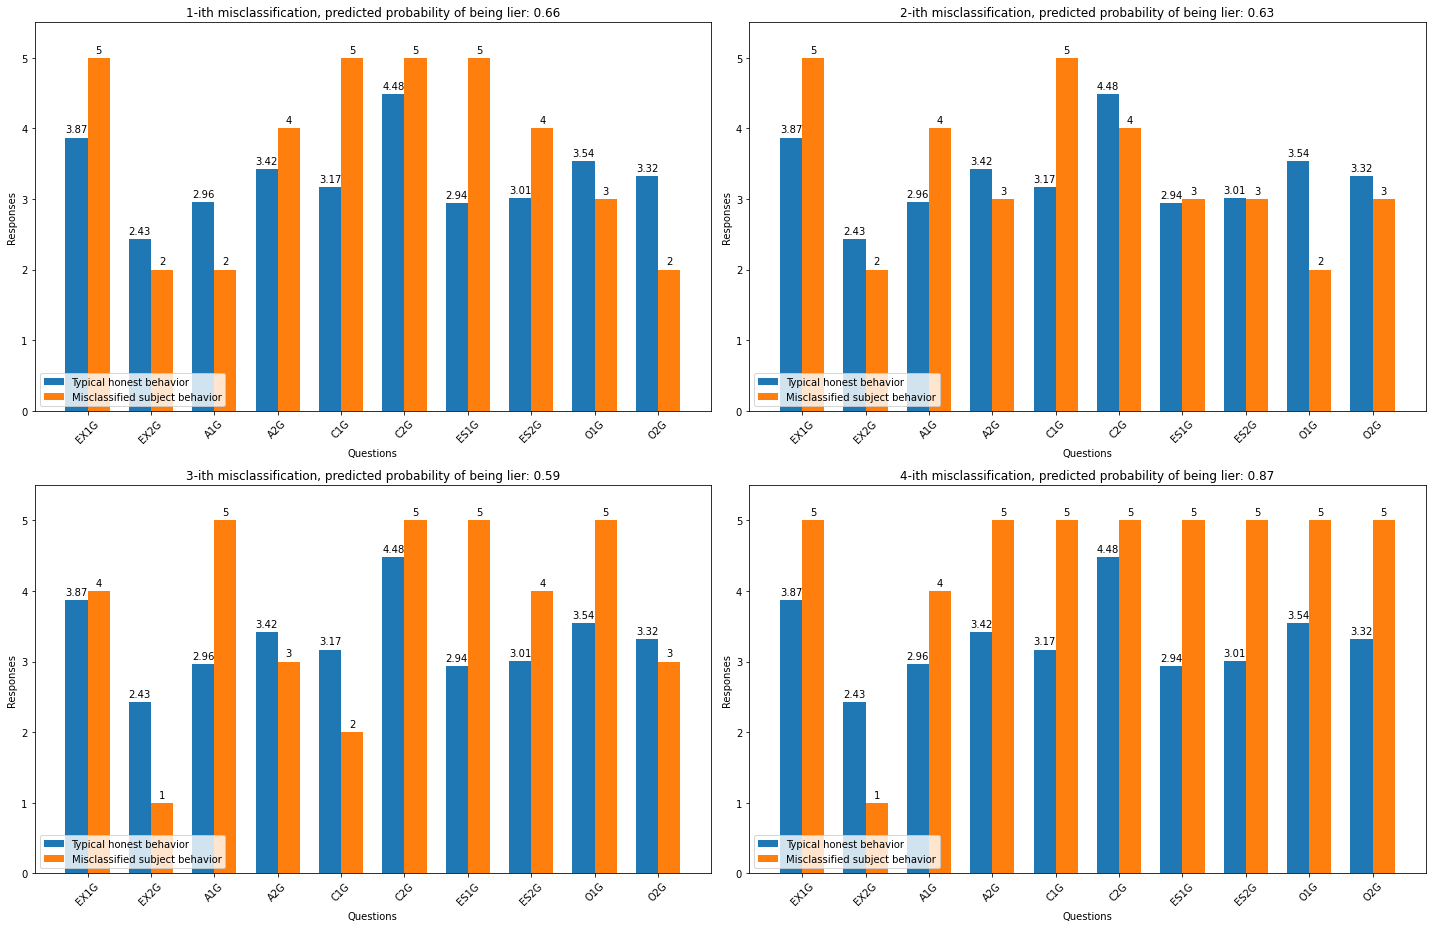

In [139]:
fig, ax = plt.subplots(2, 2, figsize=(20, 13))

for i in range(4):

    row = int(i/2)
    col = i % 2

    labels = list(data.columns[:-1])

    honest = list(x_real.mean(0).round(2))
    errs = list(errors.iloc[i, :-2])

    x = np.arange(len(labels))  
    width = 0.35  

    rects1 = ax[row, col].bar(x - width/2, honest, width, label='Typical honest behavior')
    rects2 = ax[row, col].bar(x + width/2, errs, width, label='Misclassified subject behavior')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax[row, col].set_title(str(i+1) + "-ith misclassification, predicted probability of being lier: " + 
                           str(LR.predict_proba(np.array(errs).reshape((1,-1))).round(2)[0,1])  )
    ax[row, col].set_ylabel('Responses')
    ax[row, col].set_xlabel('Questions')
    ax[row, col].set_xticks(x)
    ax[row, col].set_xticklabels(labels, rotation=45)
    ax[row, col].legend(bbox_to_anchor=(0,0), loc="lower left")
    ax[row, col].set_ylim([0,5.5])

    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax[row, col].annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')


    autolabel(rects1)
    autolabel(rects2)

fig.tight_layout()

plt.show()

The model is correcly spotting the liers, but in few examples it classifies honest people, with non-typical behavior, as liers.

# Honest adjustment

## Naive approach

All the proposed method should outperform the trivial strategy of subtracting to each subject faked response the average of the difference, across all subjects, among faked and honest response.

In [32]:
mean_train = (x_fake_train.to_numpy() - x_real_train.to_numpy()).mean(axis=0)

x_real_test_predicted = x_fake_test.to_numpy() - mean_train

test_mse = ((x_real_test_predicted - x_real_test.to_numpy()) **2).mean()
test_mse

1.5141005392425815

# Denoising autoencoder

In [33]:
dim_1 = 10
dim_2 = 5

input_vector = tf.keras.layers.Input(shape=(10,))

# Define the encoder
hidden_1 = tf.keras.layers.Dense(dim_1, activation='sigmoid')(input_vector)
encoded = tf.keras.layers.Dense(dim_2, activation='sigmoid')(hidden_1)

# ...and the decoder...
hidden_2 = tf.keras.layers.Dense(dim_1, activation='sigmoid')(encoded)
decoded = tf.keras.layers.Dense(10, activation='linear')(hidden_2)

# and finally the autoencoder
autoencoder = tf.keras.models.Model(inputs=input_vector, outputs=decoded)

autoencoder.compile(optimizer='sgd', loss='mse')

In [34]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense (Dense)                (None, 10)                110       
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_2 (Dense)              (None, 10)                60        
_________________________________________________________________
dense_3 (Dense)              (None, 10)                110       
Total params: 335
Trainable params: 335
Non-trainable params: 0
_________________________________________________________________


In [35]:
history = autoencoder.fit(x_fake_train, x_real_train, epochs=200, shuffle=True, validation_data=(x_fake_val, x_real_val),  verbose = False)

In [36]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['loss'])
  plt.plot(history.epoch,history.history['val_loss'])
  plt.legend(["Loss", "Val_loss"])
  plt.title('loss')

1/1 - 0s - loss: 1.0371
test mse: 1.03710


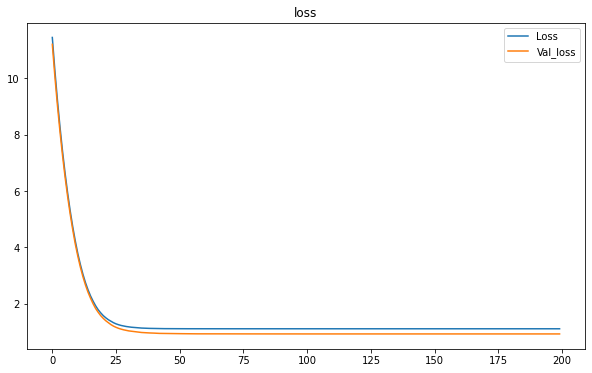

In [37]:
plot_loss(history)

scores = autoencoder.evaluate(x_fake_test, x_real_test, verbose=2)
print("test mse: %.5f" % (scores))

In [38]:
test_mse = ((autoencoder.predict(x_fake_test) - x_real_test.to_numpy())**2).mean()
test_mse

1.0371046847747238